# Load library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix , f1_score
from dataset import Dataset, create_dataset
from utils import plot_confusion_matrix , train , inference
from model import Autoencoder , VariationalAutoEncoder , Multi_ae
from explaination import local_explaination , show_local_explaination

In [2]:
# select computational device among cpu and gpu
device = torch.device('cuda:0' if not torch.cuda.is_available() else 'cpu')

# Load Data

In [3]:
# load train and test data from csv file
train_data_mae = pd.read_csv("./data/TE_fault_detection/preprocesed/train_simulated_data.csv")
#test_data_mae = pd.read_csv("./data/TE_fault_detection/preprocesed/test_simulated_data.csv")

In [4]:
# train_data_mae.drop(['Unnamed: 0'],axis=1,inplace=True)
train_data_copy = train_data_mae.copy()

sample_start = 0
fault_data_size = len(train_data_mae)
apply_rate_change = 1
if apply_rate_change :
    train_data_normal = train_data_mae[train_data_mae.fault_type == 0]
    train_data_fault1 = train_data_mae[train_data_mae.fault_type == 1]
    train_data_fault2 = train_data_mae[train_data_mae.fault_type == 2]
    train_data_fault3 = train_data_mae[train_data_mae.fault_type == 3]
    
    train_data_mae = pd.concat([train_data_normal,train_data_fault1,train_data_fault2,train_data_fault3])
    train_data_mae = train_data_mae.sample(frac=1).reset_index().drop(['index'],axis=1)
    
    train_data_f = pd.concat([train_data_normal[:fault_data_size],train_data_fault1,train_data_fault2,train_data_fault3])
    train_data_f = train_data_mae.sample(frac=1).reset_index().drop(['index'],axis=1) 

In [5]:
#train_kown_class_loader = create_dataset(train_all_data)
if apply_rate_change :
    train_data_normal_loader = create_dataset(train_data_normal)
    train_data_fault1_loader = create_dataset(train_data_fault1)
    train_data_fault2_loader = create_dataset(train_data_fault2)
    train_data_fault3_loader = create_dataset(train_data_fault3)

    train_data_loader_f = create_dataset(train_data_f,batch_size=64)
train_data_loader_n = create_dataset(train_data_mae,batch_size=64)

# Model

In [64]:
num_known_class = 4
#data_loaders = [train_data_normal_loader,train_data_fault1_loader,train_data_fault2_loader,train_data_fault3_loader]
# data_loaders = [train_data_loader_n]*num_known_class
data_loaders = [train_data_normal_loader]+[train_data_loader_n]*(num_known_class-1)
mae = Multi_ae(num_known_class,mode="VAE")
mae.train(data_loaders,100)

epoch : 1 , loss : 587.668049
epoch : 11 , loss : 591.256142
epoch : 21 , loss : 593.561562
epoch : 31 , loss : 588.856579
epoch : 41 , loss : 574.353874
epoch : 51 , loss : 594.602542
epoch : 61 , loss : 575.737218
epoch : 71 , loss : 592.518783
epoch : 81 , loss : 589.191688
epoch : 91 , loss : 601.611621
epoch : 1 , loss : 4452.466368
epoch : 11 , loss : 2042.018627
epoch : 21 , loss : 1872.825206
epoch : 31 , loss : 1729.546175
epoch : 41 , loss : 1648.328747
epoch : 51 , loss : 1567.032277
epoch : 61 , loss : 1549.522932
epoch : 71 , loss : 1559.774049
epoch : 81 , loss : 1537.772048
epoch : 91 , loss : 1535.990974
epoch : 1 , loss : 6690.379317
epoch : 11 , loss : 2038.639557
epoch : 21 , loss : 1755.327173
epoch : 31 , loss : 1642.352950
epoch : 41 , loss : 1603.042353
epoch : 51 , loss : 1564.568616
epoch : 61 , loss : 1578.020239
epoch : 71 , loss : 1679.751294
epoch : 81 , loss : 1546.589026
epoch : 91 , loss : 1566.763830
epoch : 1 , loss : 7017.368813
epoch : 11 , loss : 51

In [65]:
normalize_loss = True
if normalize_loss :
    mae.compute_recon_minmax(train_data_mae)
    mae.normalizing = True
else :
    mae.minmax_rloss_train_data = []
    mae.normalizing = False

# Inference

In [66]:
test_data_mae = pd.read_csv("./data/TE_fault_detection/preprocesed/test_simulated_data.csv")
test_data_mae_loader = create_dataset(train_data_mae,batch_size=1)

In [67]:
detect_new_class = False
col_train = test_data_mae.columns

ret_model_col = ['r_loss_normal','r_loss_fault1','r_loss_fault2','r_loss_fault3','prediction']
test_data_mae[ret_model_col] = test_data_mae[col_train].apply(lambda x  :  inference(x,mae) , axis=1)

# Evaluation metrics

In [68]:
f1_score(test_data_mae['prediction'],test_data_mae['fault_type'],average='weighted')

0.8646206091406546

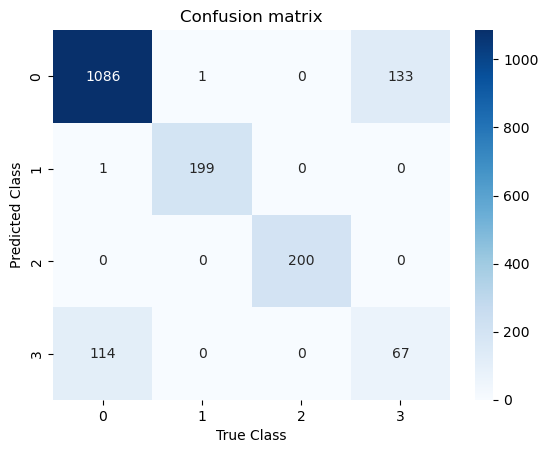

In [69]:
plot_confusion_matrix( test_data_mae['prediction'] , test_data_mae['fault_type'])

In [70]:
binary_evaluation = True
if binary_evaluation :
    test_data_mae['prediction'] = test_data_mae['prediction'].apply(lambda x : 0 if x == 0 else 1)
    test_data_mae['fault_type'] = test_data_mae['fault_type'].apply(lambda x : 0 if x == 0 else 1)

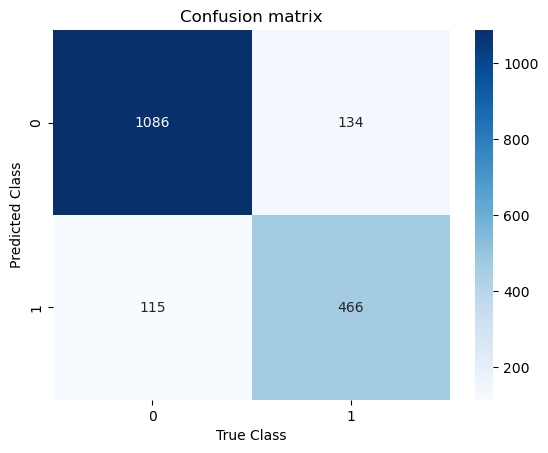

In [71]:
plot_confusion_matrix( test_data_mae['prediction'] , test_data_mae['fault_type'])

## plot result against real value over the time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


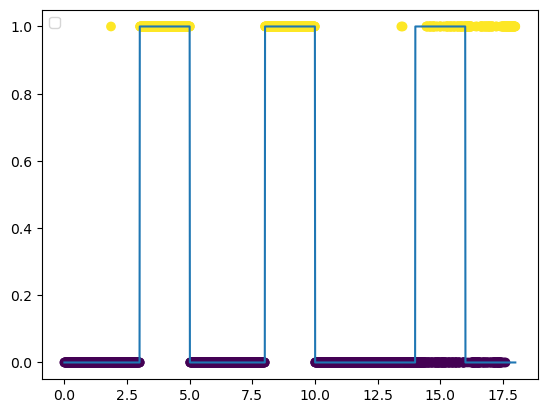

In [72]:
import matplotlib.pyplot as plt

x = range(100)
y = range(100,200)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(test_data_mae.Time, test_data_mae.fault_type)
ax1.scatter(test_data_mae.Time,test_data_mae.prediction,c=test_data_mae.prediction)
plt.legend(loc='upper left')
plt.show()

# Explainability

## local explainability

In [83]:
test_data_mae = pd.read_csv("./data/TE_fault_detection/preprocesed/test_simulated_data.csv")
data_train = pd.read_csv("./data/TE_fault_detection/preprocesed/train_simulated_data_before_scale.csv")
data_train = data_train[data_train.fault_type == 0] # get only the normal class in training data for normalization 

In [90]:
time_to_explain = 800
original = test_data_mae.iloc[time_to_explain].to_frame().T  # pick on point among 
x_reconstructed = local_explaination(test_data_mae.iloc[time_to_explain],mae.models[0])

/mnt/c/Users/j.randriarison/Documents/Jo/Research_IMT/produced_model/Explainable_Multi_AE_Fault_Detector/explaination.py:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-1, 1], [impacting_variable_line, impacting_variable_line], "k--",color='green')


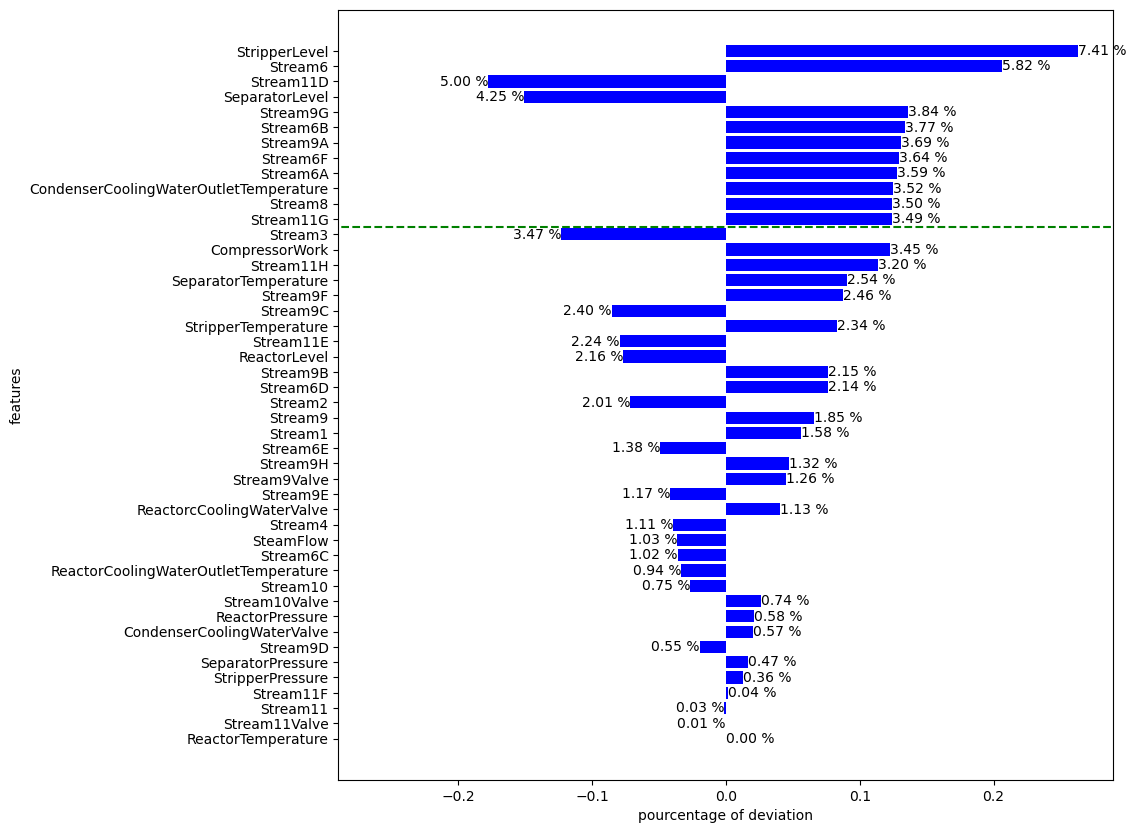

In [91]:
show_local_explaination(x_reconstructed,original,invert_transform=False,data_train=data_train,impact_pourcentage=50,plot=True,sort=True,show_pourcentage=True)